In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from wilds.datasets.wilds_dataset import WILDSSubset

from models import DeepDANN
from mixup import mixup_criterion
import options
import random

from main import get_wilds_dataset, get_split, get_eval_loader, build_model
from main import NUM_CLASSES, DEFAULT_TRANSFORM, NUM_DOMAINS, METADATA_KEYS

import sklearn
from sklearn.manifold import TSNE 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

cam_mix = 'weights/camelyon-mixup.pth'
cam_nomix = 'weights/camelyon-nomixup_final_2021-05-26T17:56:21.262615.pth'
iwild_mix = 'weights/iwildcam-mixup-3epoch_final_2021-05-25T18:25:23.230189.pth'
iwild_nomix = 'weights/from-ep2-iwildcam-mixup-3epoch_final_2021-05-26T05:52:54.712932.pth'

In [2]:
def scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, img_name):
    fig, ax = plt.subplots()
    train_fig = sns.scatterplot(x=d_train[:,0], y=d_train[:,1],hue=Y_train,palette=sns.color_palette("Blues",np.unique(Y_train).shape[0]),alpha=0.7,ax=ax)
    val_fig = sns.scatterplot(x=d_val[:,0], y=d_val[:,1],hue=Y_val,palette=sns.color_palette("Greens",np.unique(Y_val).shape[0]),alpha=0.7,ax=ax)
    test_fig = sns.scatterplot(x=d_test[:,0], y=d_test[:,1],hue=Y_test,palette=sns.color_palette("Oranges",np.unique(Y_test).shape[0]),alpha=0.7,ax=ax)


    train_fig.tick_params(bottom=False, left=False)
    train_fig.set(xticklabels=[])
    train_fig.set(yticklabels=[])
    train_norm = plt.Normalize(Y_train.min(), Y_train.max())
    train_sm = plt.cm.ScalarMappable(cmap="Blues", norm=train_norm)
    train_sm.set_array([])
    train_cax = fig.add_axes([0.25, 0.1, 0.15, 0.01])
    ax.figure.colorbar(train_sm,label="Train", ticks=[], cax=train_cax, orientation = 'horizontal')


    val_fig.tick_params(bottom=False, left=False)
    val_fig.set(xticklabels=[])
    val_fig.set(yticklabels=[])
    val_norm = plt.Normalize(Y_val.min(), Y_val.max())
    val_sm = plt.cm.ScalarMappable(cmap="Greens", norm=val_norm)
    val_sm.set_array([])
    val_cax = fig.add_axes([0.45, 0.1, 0.15, 0.01])
    ax.figure.colorbar(val_sm, label="Val", ticks=[], cax=val_cax, orientation='horizontal')

    test_fig.tick_params(bottom=False, left=False)
    test_fig.set(xticklabels=[])
    test_fig.set(yticklabels=[])
    test_norm = plt.Normalize(Y_test.min(), Y_test.max())
    test_sm = plt.cm.ScalarMappable(cmap="Oranges", norm=test_norm)
    test_sm.set_array([])
    test_cax = fig.add_axes([0.65, 0.1, 0.15, 0.01])
    ax.figure.colorbar(test_sm,label="Test", ticks=[], cax=test_cax, orientation='horizontal')


    fig.set_size_inches([6,5],forward=True)
    ax.get_legend().remove()
    sns.despine(bottom = True, left = True, right=True,ax=ax)

    fig.savefig(img_name)

In [3]:
dataset = get_wilds_dataset('camelyon17', '../WILDS')
train_data = get_split(dataset, 'train', transforms=DEFAULT_TRANSFORM['camelyon17'])
test_data = get_split(dataset, 'test', transforms=DEFAULT_TRANSFORM['camelyon17'])
val_data = get_split(dataset, 'val', transforms=DEFAULT_TRANSFORM['camelyon17'])
grouper = CombinatorialGrouper(dataset, [METADATA_KEYS['camelyon17']])
train_loader = get_train_loader('group', train_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
val_loader = get_train_loader('group', val_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
test_loader = get_train_loader('group', test_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)

[INFO] 2021-06-02 19:15:48,663 main.py:52 - Loaded dataset camelyon17 with 455954 examples



# Run Non Mix Up Experiments Below

In [4]:
# no mix up
model = build_model('densenet121', NUM_CLASSES['camelyon17'], NUM_DOMAINS['camelyon17'], 1, -1)
model.load_state_dict(torch.load(cam_nomix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [5]:
# no mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 10:
        break
val_features = np.array(val_features).reshape(-1, 1024)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 20:
        break
test_features = np.array(test_features).reshape(-1, 1024)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 1024)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(200, 1024) (200,)
val id:  [1]
(200, 1024) (200,)
test id:  [2]
(600, 1024) (600,)
val id:  [0 3 4]
50


In [6]:
# no mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)

X = np.concatenate((X_train, X_val, X_test))
Y = np.concatenate((Y_train, Y_val, Y_test))
ID_sort = np.hstack((train_id, val_id, test_id))
ID_sort = np.sort(ID_sort)
print(X.shape, Y.shape, ID_sort.shape)


pca = PCA(n_components=100)
pca.fit(X)
print(pca.singular_values_)

train: (600, 1024) (600,)
val: (200, 1024) (200,)
test: (200, 1024) (200,)
(1000, 1024) (1000,) (5,)
[121.74453     21.804565    16.312635     8.159618     7.2314715
   5.5378337    5.2390494    4.4663       4.112597     3.782417
   3.548594     3.4818327    3.3457737    3.0082319    2.761637
   2.5310915    2.2635586    2.2195857    2.1324902    2.0415406
   1.8874358    1.8449031    1.8281857    1.6821198    1.6603605
   1.5839318    1.5316476    1.4569815    1.4226114    1.3653967
   1.351298     1.2985772    1.2549217    1.2470509    1.2171525
   1.1967101    1.1390257    1.1076021    1.0981814    1.0631541
   1.023037     0.9838168    0.9618403    0.9537572    0.9490849
   0.90726036   0.8986105    0.8899609    0.8800425    0.85798377
   0.8516967    0.8347119    0.8094139    0.79973656   0.78625333
   0.76640356   0.75984174   0.756994     0.72761124   0.7120972
   0.7092683    0.70699155   0.69049335   0.6835732    0.6747323
   0.6652161    0.65420455   0.63566244   0.627205    

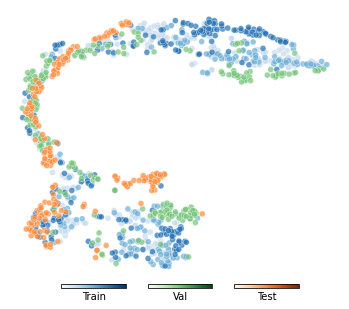

In [9]:
# no mix up

X_PCA = PCA(n_components=40).fit_transform(X)
d_X = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:600]
d_val = d_X[600:800]
d_test = d_X[800:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_no_30.png")

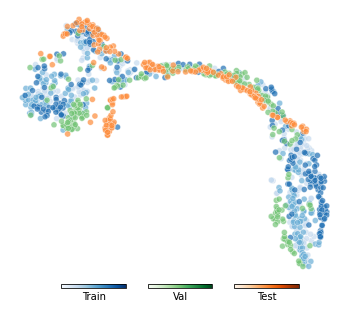

In [10]:
# no mix up
X_PCA = PCA(n_components=40).fit_transform(X)
d_X = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:600]
d_val = d_X[600:800]
d_test = d_X[800:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_no_50.png")

(600, 2) (200, 2) (200, 2)


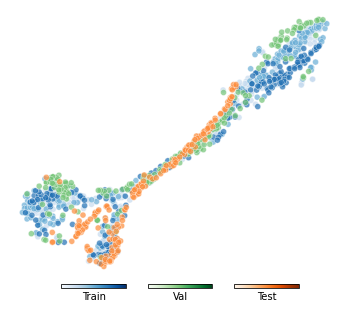

In [11]:
# no mix up
X_PCA = PCA(n_components=40).fit_transform(X)
d_X = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:600]
d_val = d_X[600:800]
d_test = d_X[800:]
print(d_train.shape, d_val.shape, d_test.shape)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_no_80.png")

# Run Mix Up Experiments Below

In [12]:
# mix up
model = build_model('densenet121', NUM_CLASSES['camelyon17'], NUM_DOMAINS['camelyon17'], 1, 1)
model.load_state_dict(torch.load(cam_mix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [13]:
# mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 10:
        break
val_features = np.array(val_features).reshape(-1, 1024)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 20:
        break
test_features = np.array(test_features).reshape(-1, 1024)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 1024)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(200, 1024) (200,)
val id:  [1]
(200, 1024) (200,)
test id:  [2]
(600, 1024) (600,)
val id:  [0 3 4]
50


In [14]:
# mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)

X = np.concatenate((X_train, X_val, X_test))
Y = np.concatenate((Y_train, Y_val, Y_test))
ID_sort = np.hstack((train_id, val_id, test_id))
ID_sort = np.sort(ID_sort)
print(X.shape, Y.shape, ID_sort.shape)


pca = PCA(n_components=100)
pca.fit(X)
print(pca.singular_values_)

train: (600, 1024) (600,)
val: (200, 1024) (200,)
test: (200, 1024) (200,)
(1000, 1024) (1000,) (5,)
[143.65118    34.61083    29.261236   19.427958   16.21357    15.12167
  10.770619   10.158438    9.474779    9.275131    7.9414506   7.6319094
   7.1350913   7.010413    6.2978253   5.938232    5.814097    5.5332117
   5.2964272   5.1839194   4.988541    4.7809033   4.6583476   4.4360695
   4.4203067   4.232703    4.0848856   4.021158    3.9048645   3.8446102
   3.735469    3.6886418   3.5335062   3.454209    3.3280745   3.2907195
   3.1909919   3.1142929   3.048586    3.033522    2.9414382   2.9121015
   2.8716526   2.8292146   2.824052    2.7458735   2.7084026   2.662186
   2.6009254   2.577501    2.5455055   2.5441756   2.4723413   2.4647887
   2.4207501   2.3859885   2.3662395   2.3395927   2.3006642   2.2612813
   2.2461228   2.2165766   2.2002444   2.1758785   2.1441295   2.097063
   2.094088    2.0536253   2.0179577   2.0082982   1.9339899   1.9264538
   1.9251573   1.8812413   

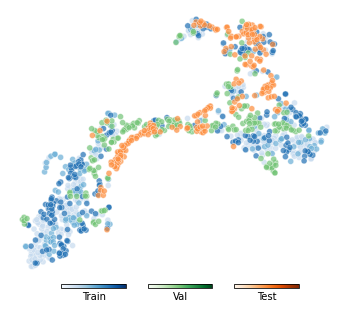

In [17]:
# mix up
X_PCA = PCA(n_components=40).fit_transform(X)
d_X = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:600]
d_val = d_X[600:800]
d_test = d_X[800:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_mix_30.png")

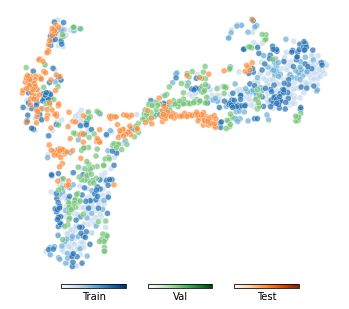

In [18]:
# mix up
X_PCA = PCA(n_components=40).fit_transform(X)
d_X = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:600]
d_val = d_X[600:800]
d_test = d_X[800:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_mix_50.png")

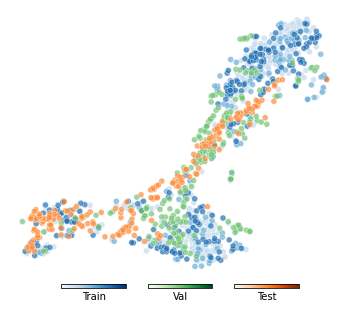

In [19]:
# mix up
X_PCA = PCA(n_components=40).fit_transform(X)
d_X = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:600]
d_val = d_X[600:800]
d_test = d_X[800:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "came_mix_80.png")